##  1. Modelado de Topics

El objetivo principal de este ejercicio es el de realizar un **análisis exploratorio** - etapa principal en cualquier problema de analítica, ML, DL y, por supuesto, NLP - de alguno de los datasets disponibles (tweets o reviews de Amazon).

Además del análisis exploratorio, se pide que el alumno realice un **modelado de topics** identificando los principales temas que aparecen en los corpus, así como los tokens que los componen.

Será muy valorable si se incluyen **gráficos descriptivos** que describan los corpus utilizados.


Importamos las librerías y funciones que vamos a necesitar.

In [1]:
import random
import pandas as pd
import os
import unicodedata
import string

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import warnings
warnings.filterwarnings('ignore')

from num2words import num2words
from stop_words import get_stop_words

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [2]:
#Función que nos devuelve el diccionario de lemas que se usará para lematizar el texto.
def get_lemmas_dict(data_path, lemmas_dict_file):
    
    lemmas_dict = {}
    
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
            
    return lemmas_dict

In [4]:
#Función que hace el preprocesado del texto: normalizar y lematizar en base a un diccionario de lemas que se le pasa.
def text_preprocess(text, lemmas_dict):
    
    processed_text = []
    
    # Convierte el texto a minúsuculas
    text = text.lower()
    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tabla para eliminar signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    
    # Segmentar texto en frases
    sentences = text.split('.')
    
    sw_list = get_stop_words('en')
       
    # Lematizar: para cada frase
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            if word not in string.punctuation and word not in sw_list and len(word)>2:  
                word = word.translate(table)
                word = lemmas_dict.get(word, word)
                if word.isdigit():
                    word = num2words(word, lang='en')
                processed_text.append(word)
    
    return processed_text
 

In [10]:
#Función que compara distintos modelos(número de topics a usar) en base a sus valores de coherencia
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [3]:
#Función que nos da el topic dominante por cada texto.
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

### CARGA DE DATOS

Tomamos de las reviews de Amazon 4 temáticas distintas y en concreto nos quedamos con 1000 de cada una para formar nuestro corpus.

In [5]:
automotive = pd.read_json('./datasets/Automotive_5.json', lines= True)
instruments = pd.read_json('./datasets/Musical_Instruments_5.json', lines= True)
office = pd.read_json('./datasets/Office_Products_5.json', lines= True)
garden = pd.read_json('./datasets/Patio_Lawn_and_Garden_5.json', lines= True)

print(f'Dimensiones del dataset de automotive: {automotive.shape}')
print(f'Dimensiones del dataset de instruments: {instruments.shape}')
print(f'Dimensiones del dataset de office: {office.shape}')
print(f'Dimensiones del dataset de garden: {garden.shape}')

#cogemos subsets de 10.000 muestras de cada categoría
redAutomotive = automotive.sample(1000)
redInstruments = instruments.sample(1000)
redOffice = office.sample(1000)
redGarden = garden.sample(1000)

#concatenamos todos los subsets
df = pd.concat([redAutomotive, redInstruments, redOffice, redGarden])
#removemos el dataframe para desordenar los subsets anteriores
df = df.sample(frac=1)

print(f'Dimensiones del dataset completo: {df.shape}')
df.head()

Dimensiones del dataset de automotive: (20473, 9)
Dimensiones del dataset de instruments: (10261, 9)
Dimensiones del dataset de office: (53258, 9)
Dimensiones del dataset de garden: (13272, 9)
Dimensiones del dataset completo: (4000, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
10563,AGGAQLXPVGM5D,B009F1R0GC,Eagle Vision,"[3, 4]",What is in the box?Sprinkler systemWhat is not...,5,Don't hurt 'em. Just squirt 'em,1365552000,"04 10, 2013"
2965,A1GMWTGXW682GB,B0002H0SKS,MetalFan,"[0, 0]",I read good reviews about these strings on myl...,5,Used with a Les Paul and a homemade Cigar Boix...,1392854400,"02 20, 2014"
4497,A30X750M8V1XXW,B000SP2JLU,Scott,"[0, 0]","Well, although it works like its supposed to (...",2,Squirrels find a way still,1362614400,"03 7, 2013"
1230,A1E31MMY0SL9J7,B00005T407,"Car Enthusiast ""Car Enthusiast""","[0, 0]","Pretty good product for the money, It is hand...",5,Very good,1385769600,"11 30, 2013"
22296,AW5JSQCHC2ZJO,B002K9M7MS,Basil MacDougal,"[0, 0]",What a life saver these were this holiday seas...,5,3M Shipping Labels,1260835200,"12 15, 2009"


Nos quedamos simplemente con la columna de la review. Se trata de un ejercicio de aprendizaje no supervisado, así que no tendremos una variable objetivo con la que comparar ni evaluar nuestro modelo.

In [6]:
df = df[['reviewText']]
df.head()

,reviewText
10563,What is in the box?Sprinkler systemWhat is not...
2965,I read good reviews about these strings on myl...
4497,"Well, although it works like its supposed to (..."
1230,"Pretty good product for the money, It is hand..."
22296,What a life saver these were this holiday seas...


### PREPROCESADO

Hacemos el preprocesado del texto. Básicamente normalizamos de la siguiente manera:
- pasamos a minúsculas
- quitamos caracteres extraños
- quitamos signos de puntuación
- quitamos stop_words y palabras de 1 ó 2 caracteres
- lematizamos
- convertimos a letras los números


In [7]:
data_path = './data'
lemmas_dict_file = 'lemmatization-en.txt'

lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)
#lemmas_dict

processed_texts = []
for text in df['reviewText']:
    processed_texts.append(text_preprocess(text, lemmas_dict))

### MODELO LDA

Siguiendo las recomendaciones de clase, para resolver este ejercicio de topic modeling vamos a usar un **modelo LDA**. Para ello necesitamos el diccionario id-palabra y la matriz documento término. 

In [8]:
dictionary = Dictionary(processed_texts)
list(dictionary.items())

corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

print(f'Númeo de palabras del diccionario: {len(dictionary)}')

Númeo de palabras del diccionario: 15558


En este ejercicio somos conocedores del dataset de entrada ya que lo hemos formado nosotros, y sabemos que se deberían distinguir 4 topics principalmente:
- Musical Instruments
- Patio, Lawn and Garden
- Automotive
- Office Products

No obstante, vamos a hacer una simulación para ver cuántos serían el número óptimo de topics:

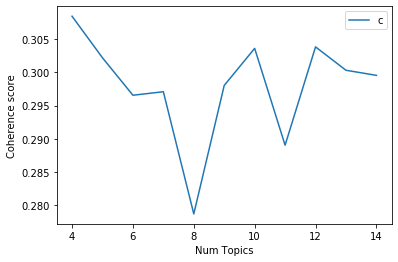

In [11]:
start_ = 4
end_ = 15
step_ = 1

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

Vemos que los valores son bastante similares, teniendo los máximos en 4, 10 y 12.
Por coherencia con la formación del dataset original y por simplicadad a la hora de agrupar los topics vamos a trabajar con 4.

**Entrenamos el modelo LDA**

In [12]:
num_topics = 4

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

Una vez lo tenemos entrenado podemos ver los 4 topic que ha identificado y con las palabras con más peso para cada una de las categorías.

In [13]:
lda_model.show_topics()

[(0,
  '0.023*"use" + 0.019*"good" + 0.011*"work" + 0.010*"get" + 0.010*"can" + 0.009*"product" + 0.009*"one" + 0.008*"just" + 0.007*"clean" + 0.007*"great"'),
 (1,
  '0.014*"use" + 0.010*"printer" + 0.009*"print" + 0.008*"can" + 0.008*"good" + 0.008*"paper" + 0.007*"battery" + 0.007*"label" + 0.006*"work" + 0.006*"one"'),
 (2,
  '0.014*"use" + 0.011*"guitar" + 0.010*"like" + 0.010*"one" + 0.010*"good" + 0.009*"work" + 0.008*"great" + 0.008*"sound" + 0.008*"buy" + 0.008*"get"'),
 (3,
  '0.012*"use" + 0.011*"one" + 0.009*"get" + 0.008*"will" + 0.007*"trap" + 0.007*"feeder" + 0.007*"like" + 0.006*"good" + 0.006*"make" + 0.006*"little"')]

Ahora listamos las 20 palabras más significativas para cada uno de los topic.

In [14]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04
0,use,use,use,use
1,good,printer,guitar,one
2,work,print,like,get
3,get,can,one,will
4,can,good,good,trap
5,product,paper,work,feeder
6,one,battery,great,like
7,just,label,sound,good
8,clean,work,buy,make
9,great,one,get,little


A simple vista parece que no es fácil identificar los topics. Hay muchas palabras "genéricas" que diferencian poco. Es el ejemplo de: use, good, one, work, like, get, can, will, product... Se pueden usar para hablar de casi cualquier cosa.

Vamos a profundizar un poco más en el análisis y para ello vamos a usar la **visualización del LDA de gensim**. Lo guardo en un .html para que se pueda trabajar con él de forma independiente.
Es una herramienta muy potente, como vamos a poder ver a continuación.

In [15]:
# Visualizar los topics y guardar el html
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

pyLDAvis.save_html(vis, './topic_visualization.html')

**Visualizamos el .html y obtenemos lo siguiente:**
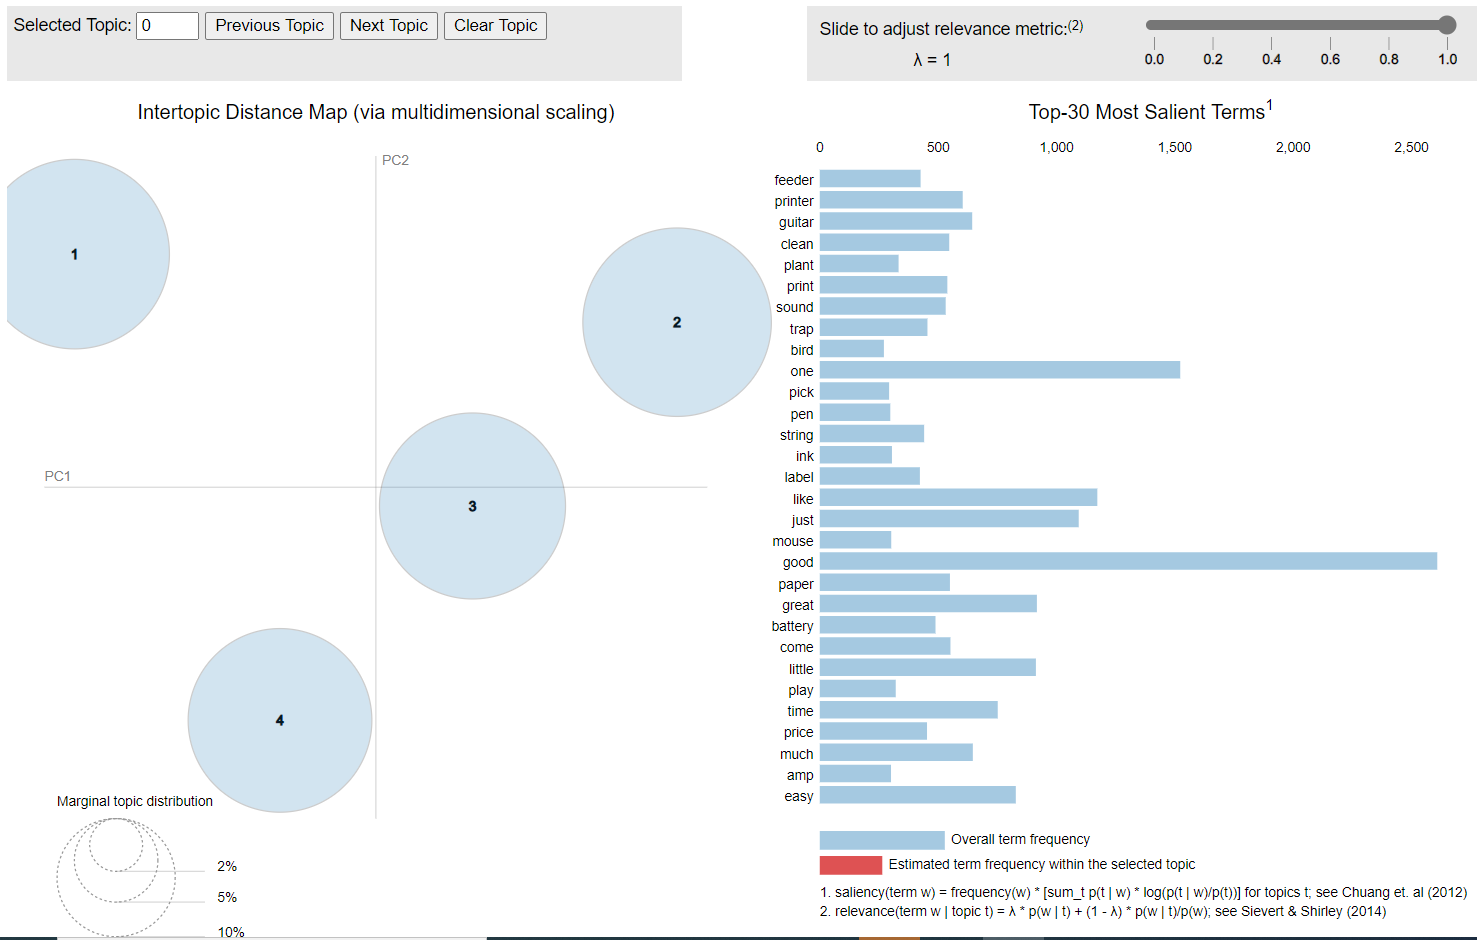

Tenemos 4 topics bien diferenciados y son de tamaños similares. Esto nos muestra que las palabras que identifican cada uno de ellos están repartidos de forma más o menos similar (tiene lógica ya que hemos cogido el mismo número de reviews de cada temática), y además no existe mucho solapamiento, por lo que parece que son palabras distintas para cada topic.

Ahora vamos a ir haciendo zoom en cada uno de los topics para estudiarlos por separado. Es importante mencionar el parámetro lambda. Con él vamos a dar más importancia a las palabras que aparecen de forma exclusiva en un topic y no en varios. Se aprecia fácilmente en la gráfica si nos fijamos en el color rojo de las barras. El color azul significa que también aparece en otros topics.

**Para el topic 1 destacamos:** printer, print, paper, ink, scan, cartridge... así que lo podemos relacionar con la temática de Office Products.
Podría parecer que no he lematizado o que está mal hecho, ya que aparecen printer y print, pero si vamos a nuestro diccionario de lemas se observa que están las dos palabras.

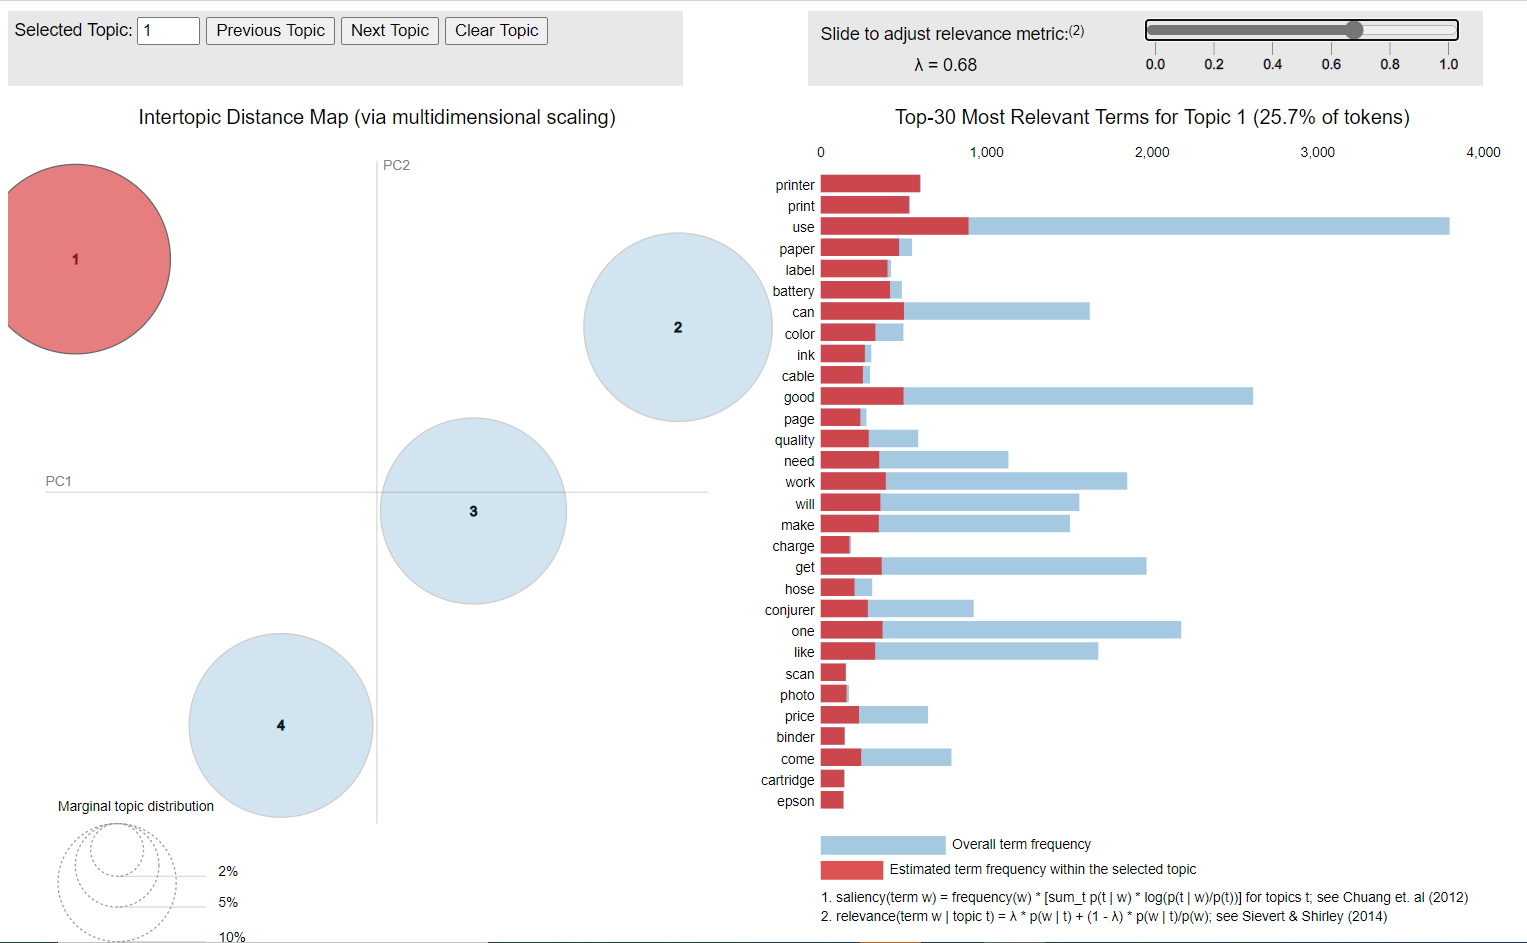

**Para el topic 2 destacamos:** trap, feeder, plant, mouse, bird, squirrel, seed... y por tanto lo relacionamos claramente con la categoría Patio, Lawn and Garden.
Aquí se puede apreciar que se podrían usar bigramas para diferenciar más aún. Está el ejemplo de mouse trap y mouse. El primero hace alusión a una trampa para cazar ratones y el segundo lo podemos interpretar como material informático.

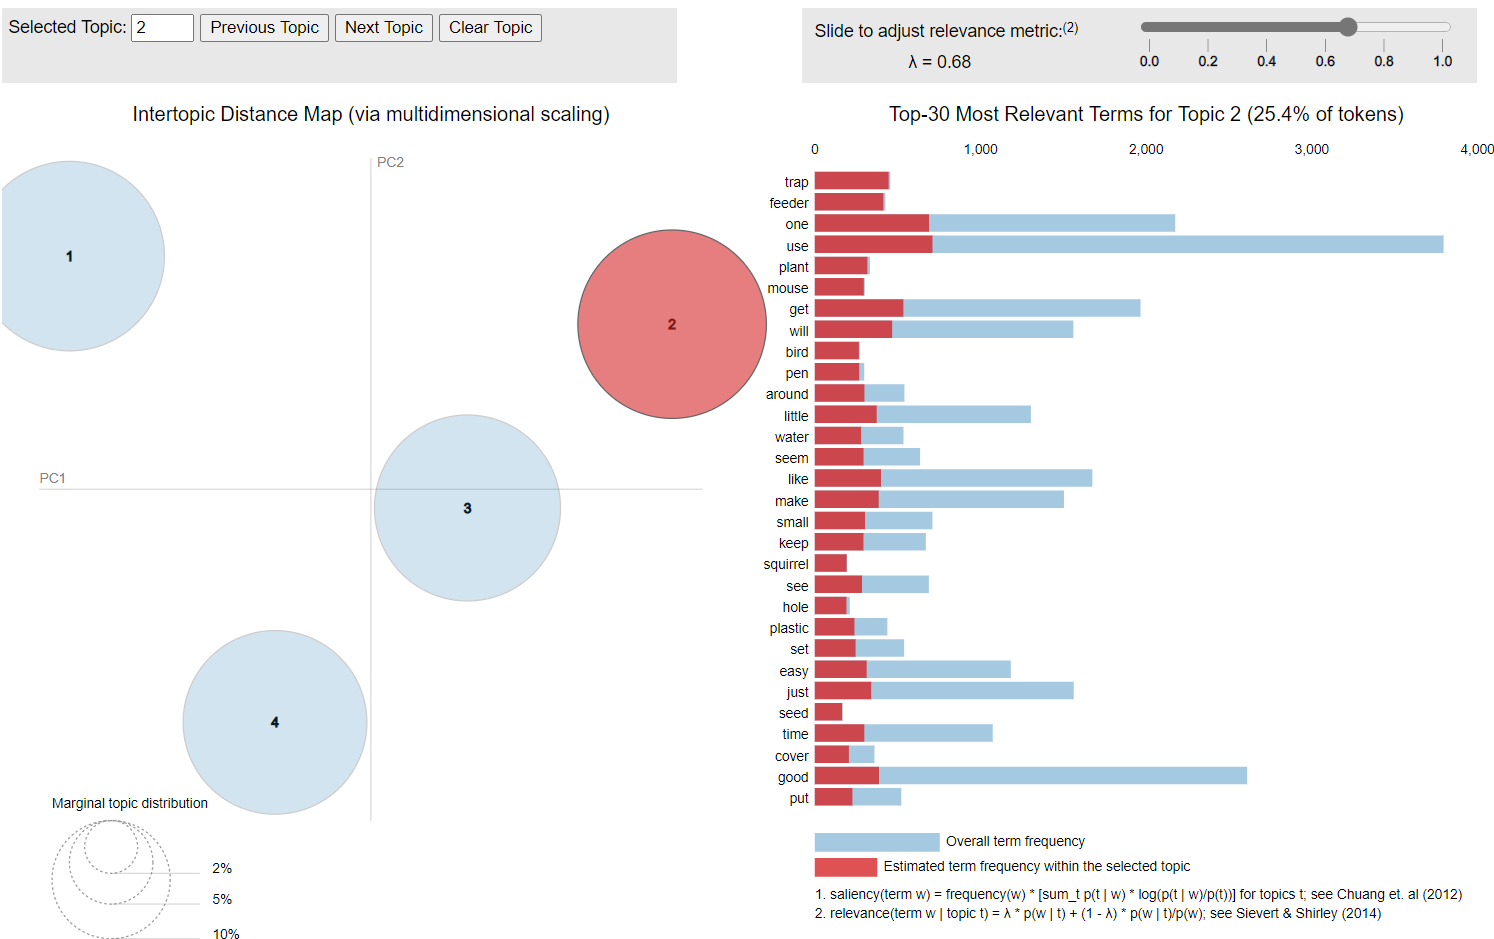

**Para el topic 3 destacamos:** Hay muchas palabras que se usan en el resto del corpus para otros topics. Quizá sea el que peor definido está de los 4. No obstante, hay una palabra clave: car, que hace que nos decantemos por la temática de Automotive. Luego hay otras cuantas que bien podríamos relacionar con el tema coches y su limpieza o mantenimiento como clean, tape, grill, spray, wash or stick. Pero es cierto, que son palabras que también se podrían relacionar con otros topics.

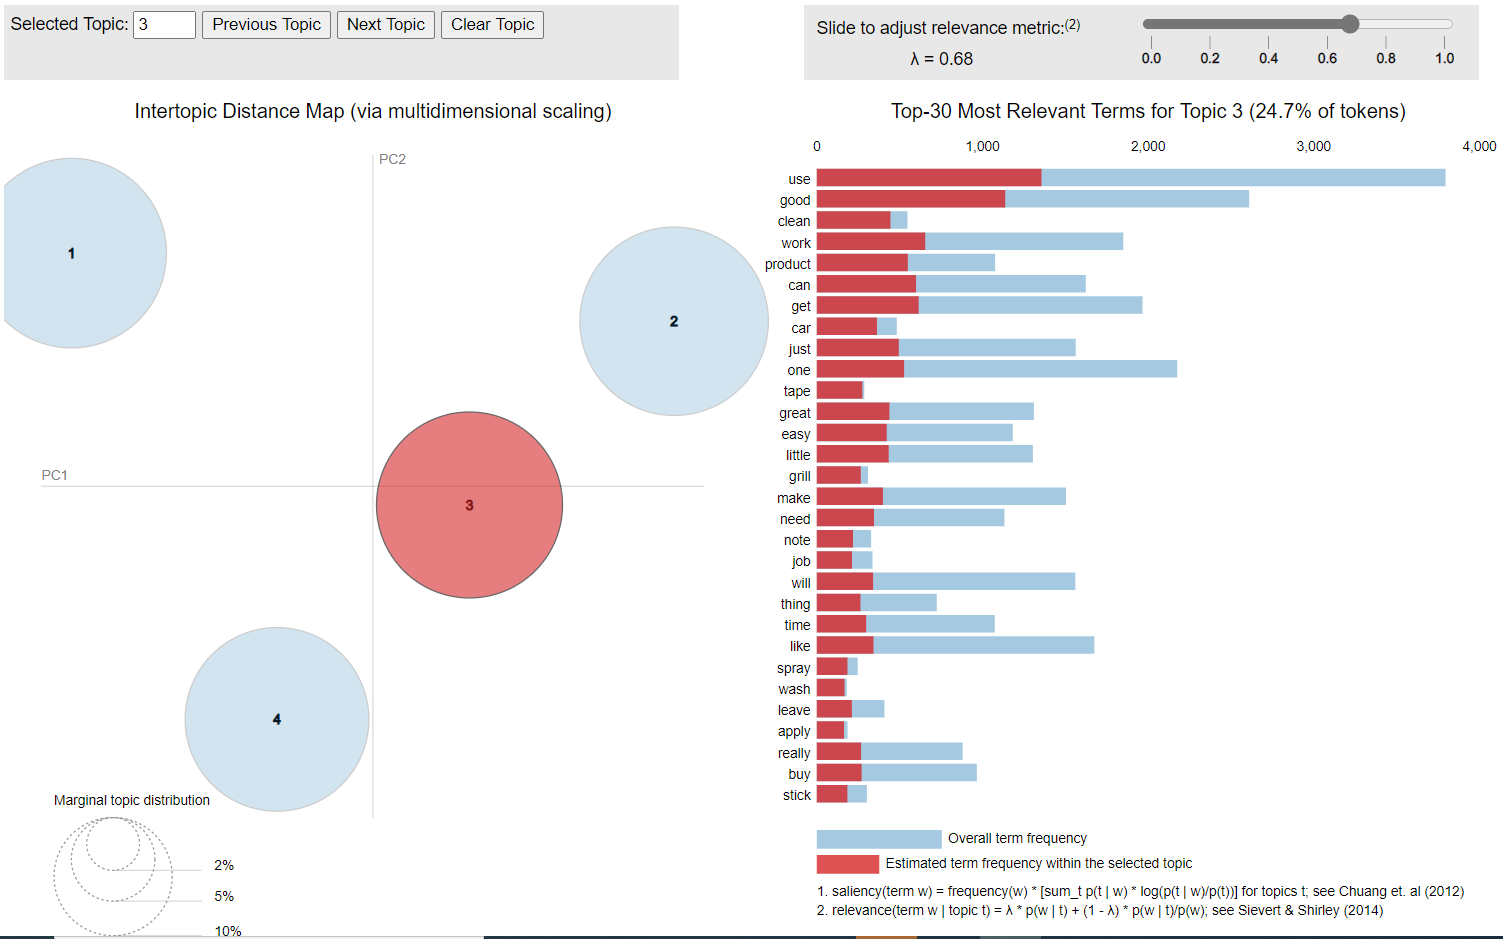

**Para el topic 4 destacamos:** guitar, sound, string, play, amp, pedal, pick... que nos hacen pensar directamente en la temática de Musical Instruments.

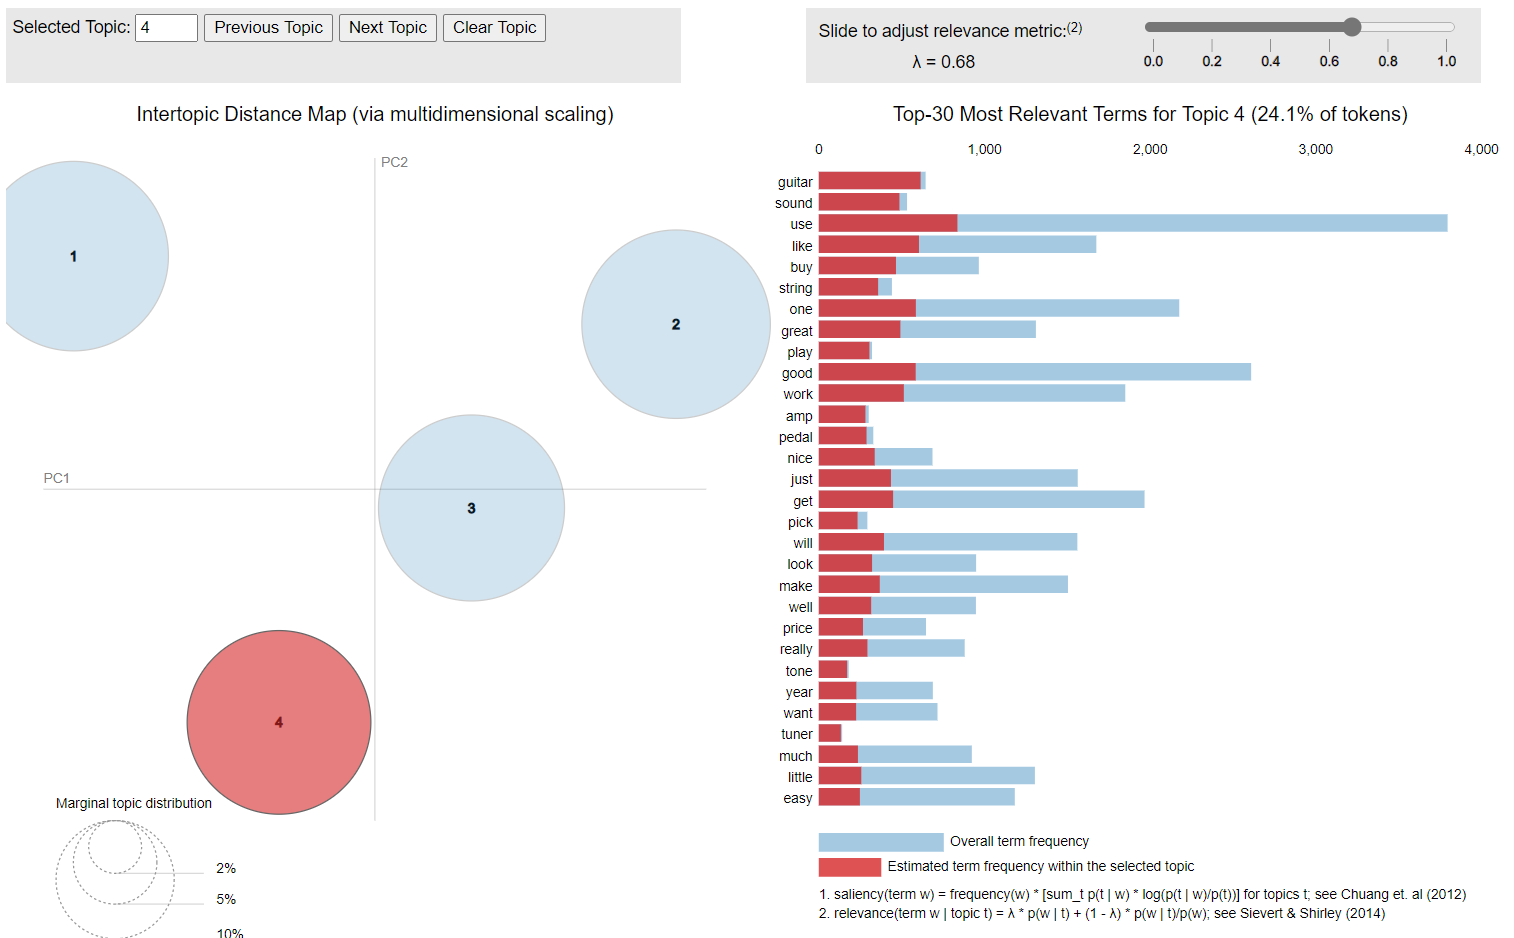



### CONCLUSIONES

Es decir, **podemos concluir que en este caso el modelo LDA ha diferenciado bien los topics. Pero para llegar a esta conclusión ha sido necesario usar la herramienta de visualización de gensim, ya que las listas de keywords y topN de cada topic no son tan evidentes.**

No obstante, es importante comentar que aquí ya sabíamos las temáticas de antemano, por lo que nuestra búsqueda y análisis está muy influenciado.
En casos similares donde no se obtenga claramente esas diferenciaciones de topics se podría seguir trabajando en estas líneas:
- reducir el número de palabras que no aportan diferenciación. Aquellas palabras que se repiten mucho en nuestro corpus para todos los topics.
- añadir n-gramas para diferenciar más aún (mouse trap por ejemplo).

Para finalizar, vamos a mostrar una serie de tablas resumen que pueden ser útiles para identificar los topic, aunque como hemos comentado ya, no son tan claros como la visualización de pyLDAvis de gensim:

**TOPIC DOMINANTE POR TEXTO**

In [16]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=processed_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Mostramos a modo de ejemplo las 10 primeras reviews y su topic
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4318,"use, good, work, get, can, product, one, just,...","[boxsprinkler, systemwhat, box4, batteriescons..."
1,1,2.0,0.7474,"use, guitar, like, one, good, work, great, sou...","[read, good, review, string, mylespaul, com, a..."
2,2,3.0,0.7921,"use, one, get, will, trap, feeder, like, good,...","[good, although, work, like, suppose, so, far,..."
3,3,0.0,0.3898,"use, good, work, get, can, product, one, just,...","[pretty, good, product, money, handy, job, sol..."
4,4,1.0,0.5288,"use, printer, print, can, good, paper, battery...","[life, saver, holiday, season, already, use, h..."
5,5,0.0,0.5482,"use, good, work, get, can, product, one, just,...","[can, finally, stop, use, flashlight, check, d..."
6,6,3.0,0.5548,"use, one, get, will, trap, feeder, like, good,...","[excellent, dig, tool, one, matte, blade, use,..."
7,7,0.0,0.8009,"use, good, work, get, can, product, one, just,...","[impress, heavy, duty, grill, brush, bristle, ..."
8,8,0.0,0.3475,"use, good, work, get, can, product, one, just,...","[well, full, synthetic, motor, oil, can, buy, ..."
9,9,3.0,0.5509,"use, one, get, will, trap, feeder, like, good,...","[lady, bug, arrive, great, condition, dead, on..."


Para cada texto, en este caso para cada review, lo asocia con el topic que mejor lo representa.

**DOCUMENTO MÁS REPRESENTATIVO POR TOPIC**

In [17]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9628,"use, good, work, get, can, product, one, just,...","[use, pad, final, polish, sealant, application..."
1,1.0,0.9709,"use, printer, print, can, good, paper, battery...","[unit, test, window, home, premium, desktop, w..."
2,2.0,0.9375,"use, guitar, like, one, good, work, great, sou...","[far, amp, model, vintage, tone, well, ear, li..."
3,3.0,0.9411,"use, one, get, will, trap, feeder, like, good,...","[springtime, mean, woodchuckgroundhogs, full, ..."


Aquí tenemos la review que mejor define cada topic.

**DISTRIBUCIÓN DE TOPICS EN EL CORPUS**

In [18]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

,topic,contribution
0,2.0,0.2878
1,0.0,0.2828
2,1.0,0.2222
3,3.0,0.2072


Como ya hemos comentado anteriormente, el reparto de topics en el corpus es casi homogéneo. Coincide con la elección inicial que hicimos de 1000 reviews por cada temática.